In [1]:
from main import *
from visualization import *
from stats import *

from scipy.stats import spearmanr

%matplotlib inline
plt.rcParams['font.size'] = 12

delete = delete_rows_and_columns

color1 = [0, 0, 0]
color3 = [1, 1, 1]
blue = hex2rgb('#006DAA')
cmap = make_cmap([color1, blue, color3], [0, 0.5, 1])

# Figure 2 analyses

In [2]:
atlas_path = '/home/anleg84/Documents/Atlas/MapzebrainOld/'
atlas = MapzebrainAtlas(atlas_path)

SC = np.load('Data/undirected_terminals_expanded.npy')
SC_dir = np.load('Data/directed_terminals_expanded.npy')
excluded = np.load('Results/excluded_regions.npy')

FC = np.load('Results/FC_matrix.npy')
R = FC.shape[0]
triangle = np.triu_indices(FC.shape[0], 1)

# Baseline SC-FC correlation

In [3]:
triangle = np.triu_indices(FC.shape[0], 1)

SC_FC_corr = pearsonr(FC[triangle], delete(SC, excluded)[triangle])[0]
print(SC_FC_corr)

0.5678666489568499


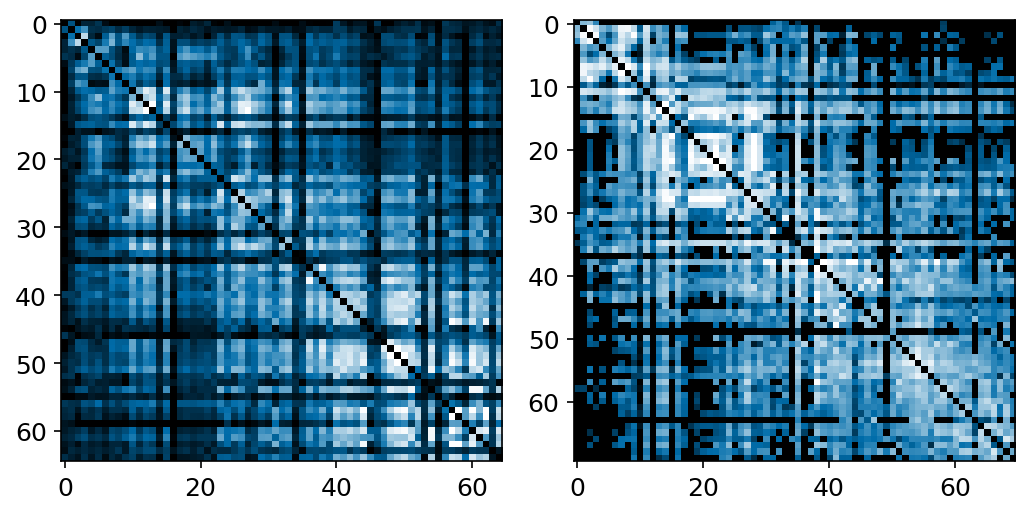

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), dpi=150)
ax[0].imshow(FC, vmin=0.1, vmax=0.9, cmap=cmap)
ax[1].imshow(SC, vmin=0.1, vmax=0.9, cmap=cmap)

plt.tight_layout(pad=1)
#plt.savefig('Figures/Figure2/FC_SC_matrices.svg')

# Degrees correlation

In [5]:
np.save('Results/figure2_degree_SC.npy', np.sum(delete(SC, excluded), axis=1))
np.save('Results/figure2_degree_FC.npy', np.sum(FC, axis=1))

Text(0, 0.5, 'Weighted functional degree')

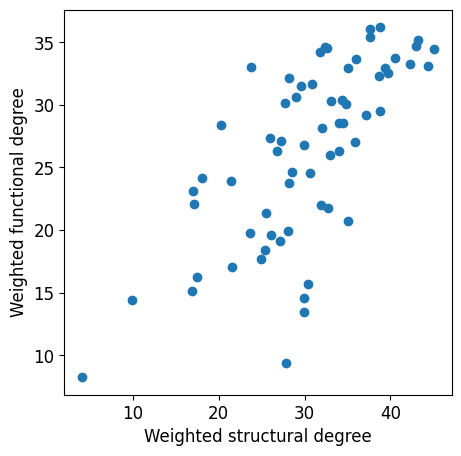

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(np.sum(delete(SC, excluded), axis=1), np.sum(FC, axis=1))
plt.xlabel('Weighted structural degree')
plt.ylabel('Weighted functional degree')

In [7]:
pearsonr(np.sum(delete(SC, excluded), axis=1), np.sum(FC, axis=1))

(0.6937727891211727, 1.4849549093079799e-10)

# FC of reciprocal structural connections

In [8]:
def plot_smooth_histogram(ax, data, bins, N_interp=1000, sigma=20, density=False, color='black', edgecolor='black', alpha=1):
    h1 = np.histogram(data, bins=bins, density=density)
    #plt.close()
    y1 = gaussian_filter1d(interpolate_signal(h1[0], N_interp), sigma)
    x1 = interpolate_signal(h1[1], N_interp)
    ax.fill_between(x1, 0, y1, color=color, edgecolor=edgecolor, alpha=alpha)

def compute_directionality_distributions(networks, connectome):
    binary_connections = (connectome > 0).astype('int')
    number_of_connections = binary_connections + binary_connections.T
    corrs_0, corrs_1, corrs_2 = [], [], []
    triangle = np.triu_indices(connectome.shape[0], 1)
    for network in networks:
        corrs_0.append(network[triangle][number_of_connections[triangle] == 0])
        corrs_1.append(network[triangle][number_of_connections[triangle] == 1])
        corrs_2.append(network[triangle][number_of_connections[triangle] == 2])
    corrs_0 = np.array(corrs_0).flatten()
    corrs_0 = corrs_0[corrs_0 != 0]
    corrs_1 = np.array(corrs_1).flatten()
    corrs_1 = corrs_1[corrs_1 != 0]
    corrs_2 = np.array(corrs_2).flatten()
    corrs_2 = corrs_2[corrs_2 != 0]
    return corrs_0, corrs_1, corrs_2

In [9]:
FC_matrices = np.load('Results/FC_matrices.npy')

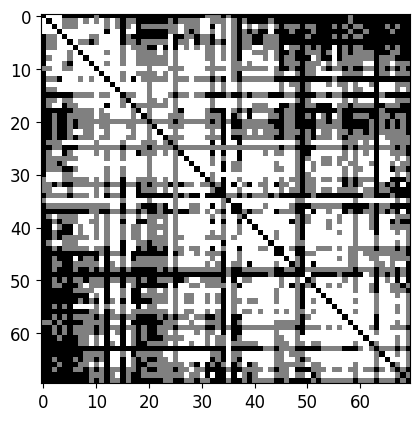

In [10]:
binary_connections = (SC_dir > 0).astype('int')
number_of_connections = binary_connections + binary_connections.T

plt.imshow(number_of_connections, cmap='gray')

#plt.savefig('Figures/Figure2/directionality_matrix.svg'))

In [11]:
np.save('Results/number_of_connections.npy', number_of_connections)

In [12]:
corrs_0, corrs_1, corrs_2 = compute_directionality_distributions(FC_matrices, delete(SC_dir, excluded))

In [13]:
np.save('Results/figure2_directionality_corrs0.npy', corrs_0)
np.save('Results/figure2_directionality_corrs1.npy', corrs_1)
np.save('Results/figure2_directionality_corrs2.npy', corrs_2)

(0.0, 2.3)

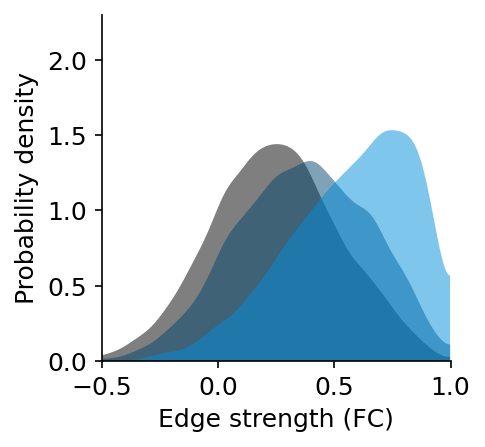

In [14]:
bins = np.linspace(-1, 1, 50)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
plot_smooth_histogram(ax, corrs_0, bins, sigma=20, color='black', edgecolor='none', alpha=0.5, density=True)
plot_smooth_histogram(ax, corrs_1, bins, sigma=20, color=0.65 * blue, edgecolor='none', alpha=0.5, density=True)
plot_smooth_histogram(ax, corrs_2, bins, sigma=20, color=1.3 * blue, edgecolor='none', alpha=0.5, density=True)
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('Edge strength (FC)')
plt.ylabel('Probability density')
plt.xlim([-0.5, 1])
plt.ylim([0, 2.3])

# Structural predictors of FC

In [18]:
from predictors import *

In [19]:
N_regions = FC.shape[0]

In [20]:
model = Predictors(SC_dir, SC, atlas.computeDistanceBetweenRegions(), excluded=excluded)
model.compute_predictors(directed=True)

In [21]:
correlations_single = model.correlate_single_predictors(FC)
Rsquared_single = []
for c in correlations_single:
    Rsquared_single.append(c ** 2)

In [22]:
baseline_corr = pearsonr(FC[triangle], delete(model.A_und, excluded)[triangle])[0]

Rsquared_baseline = baseline_corr ** 2

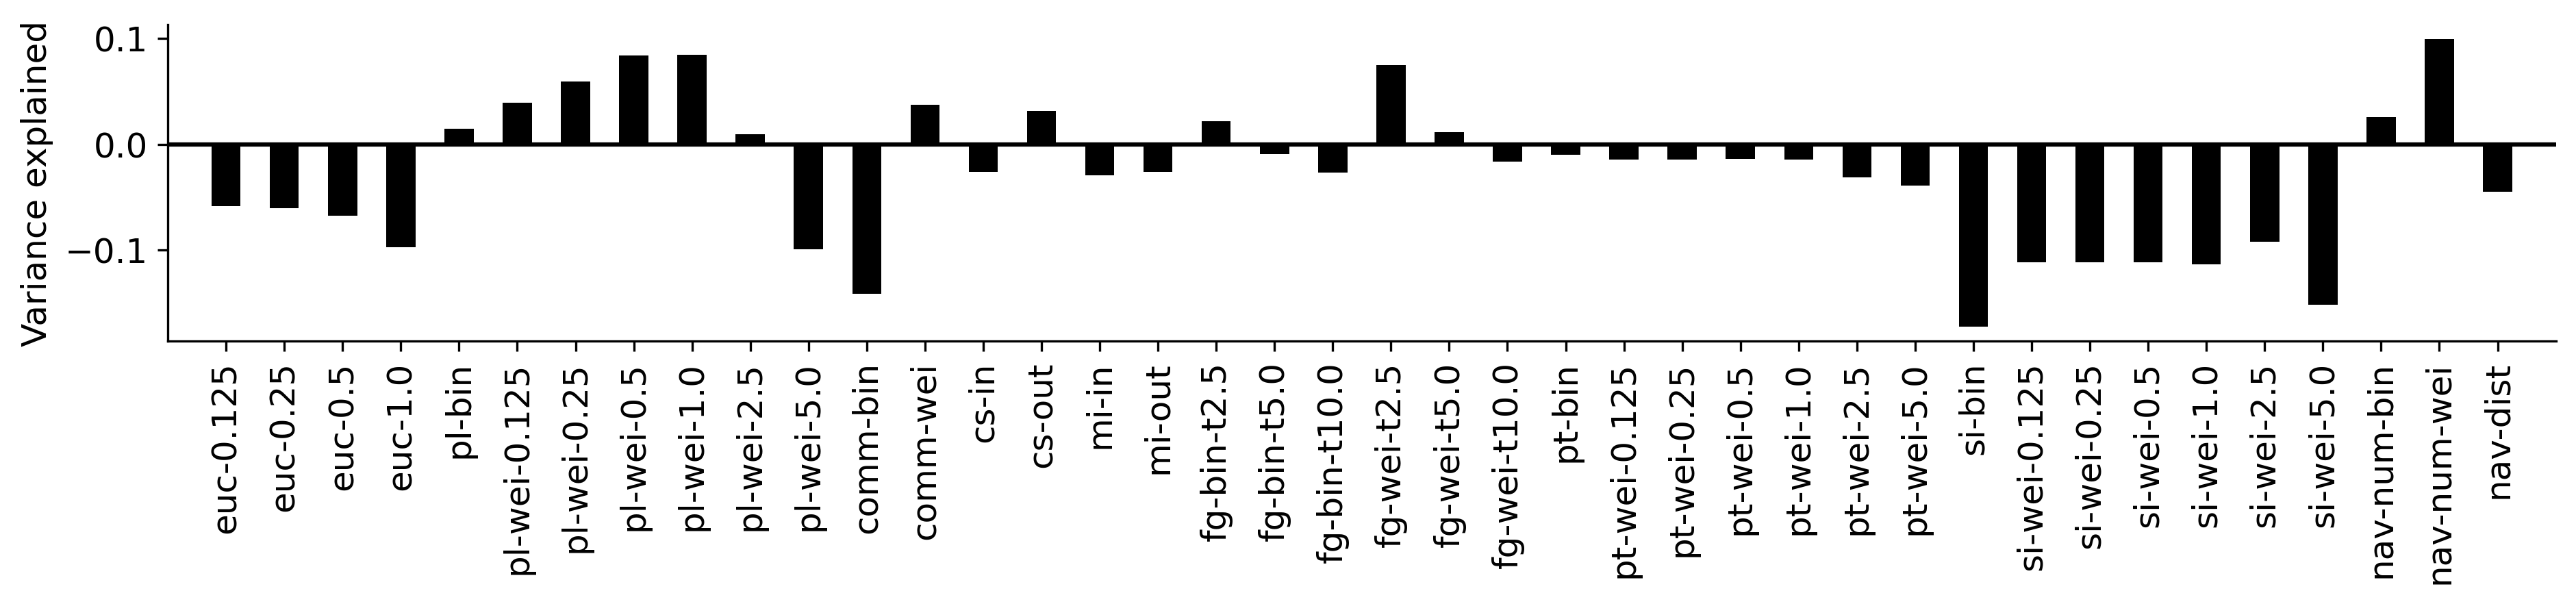

In [23]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
plt.bar(np.arange(model.predictors.shape[1]), np.abs(Rsquared_single) - Rsquared_baseline, color='black', width=0.5)
plt.plot([0 - 1, model.predictors.shape[1] ], [0, 0], color='black')
plt.xticks(np.arange(model.predictors.shape[1]), model.predictors_names, rotation=90)
plt.xlim([-1, model.predictors.shape[1] ])
ax.spines[['top', 'right']].set_visible(False)
plt.ylabel('Variance explained')
plt.show()

In [24]:
np.save('Results/figure2_rsquared_single.npy', Rsquared_single)
np.save('Results/figure2_rsquared_baseline.npy', Rsquared_baseline)
np.save('Results/figure2_predictors_names.npy', np.array(model.predictors_names))

#### Extracting principal components

In [25]:
from sklearn.decomposition import PCA

Inter-predictor correlations

In [26]:
predictors = model.predictors

In [27]:
predictors.shape

(4225, 40)

In [28]:
interpredictor_correlations = np.corrcoef(predictors.T)[np.triu_indices(predictors.shape[1], 1)]

In [29]:
print('Mean +/- std')
print(np.mean(interpredictor_correlations), np.std(interpredictor_correlations))

Mean +/- std
0.653342601617997 0.162390610796512


In [30]:
predictors = model.predictors
mean_predictor = np.mean(predictors, axis=1).reshape(N_regions, N_regions)

In [31]:
pca = PCA(n_components=10).fit(predictors)
components = pca.fit_transform(predictors)
expvar = pca.explained_variance_ratio_
loadings = pca.components_.T

In [32]:
np.save('Results/figure2_PCA_expvar.npy', expvar)

Text(0, 0.5, 'Explained variance')

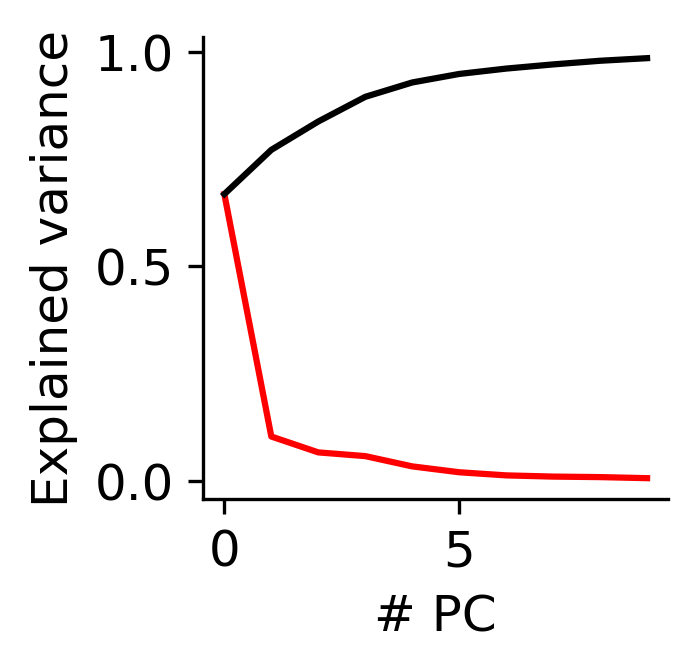

In [33]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.plot(expvar[:10], color='red', label='Fraction of variance')
ax.plot(np.cumsum(expvar)[:10], color='black', label='Cumulative variance')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('# PC')
ax.set_ylabel('Explained variance')

In [34]:
print(expvar[0])

0.6683325172770703


In [35]:
PCs = []
for i in range(components.shape[1]):
    PC = components[:, i].reshape(N_regions, N_regions)
    PC[np.diag_indices(PC.shape[0])] = 0
    PCs.append(np.sign(pearsonr(PC[triangle], FC[triangle])[0]) * PC)

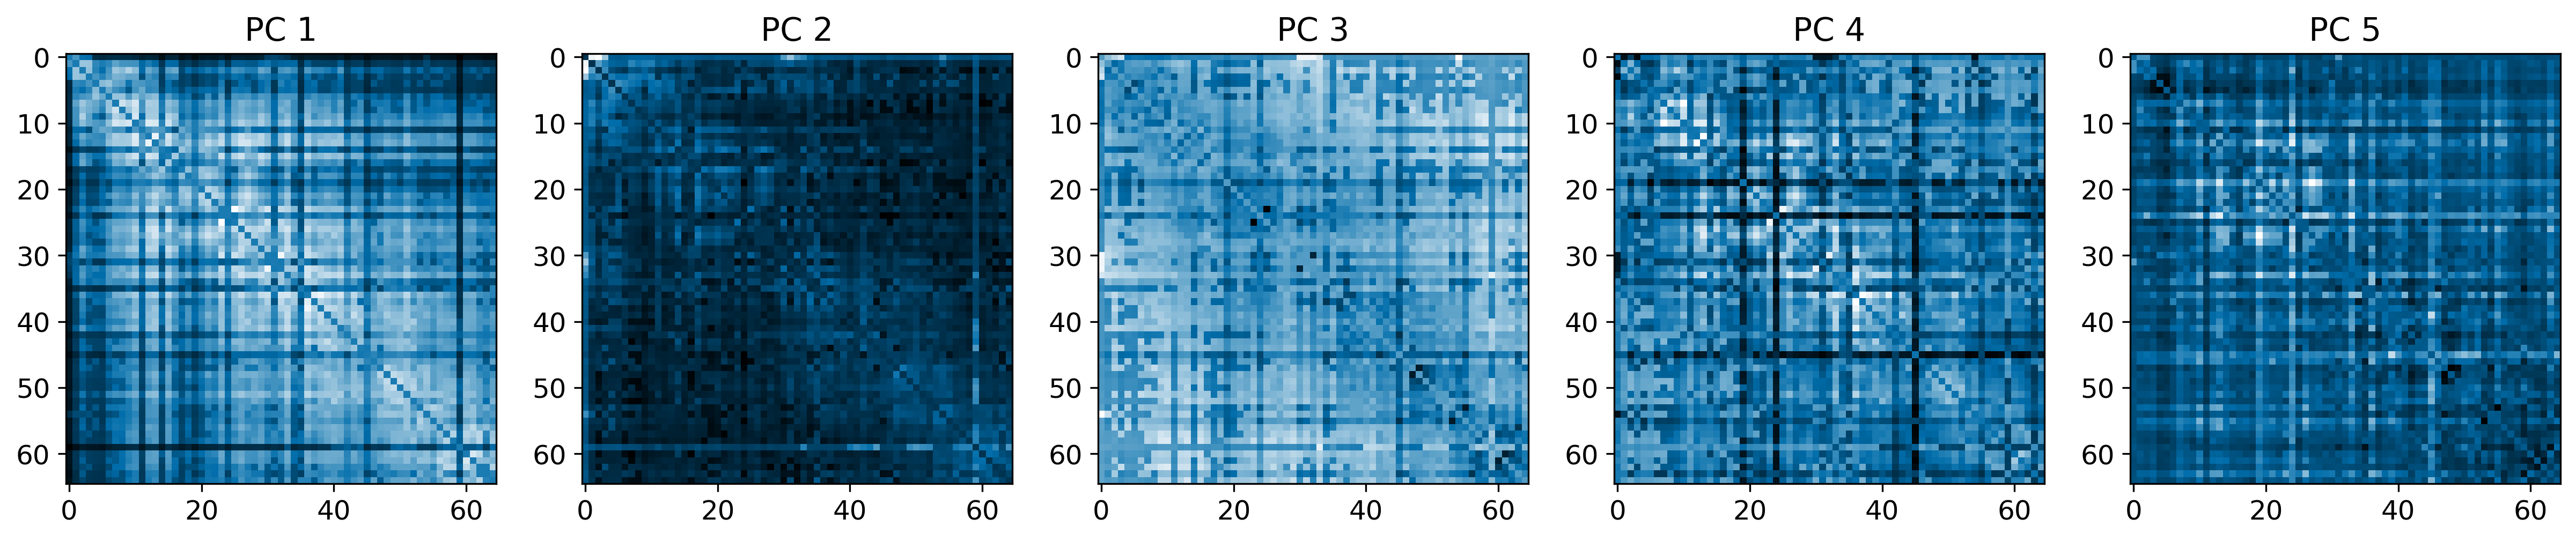

In [36]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), dpi=300)
for i, PC in enumerate(PCs[:5]):
    ax[i].imshow(PC, cmap=cmap)
    ax[i].set_title('PC {}'.format(i + 1))

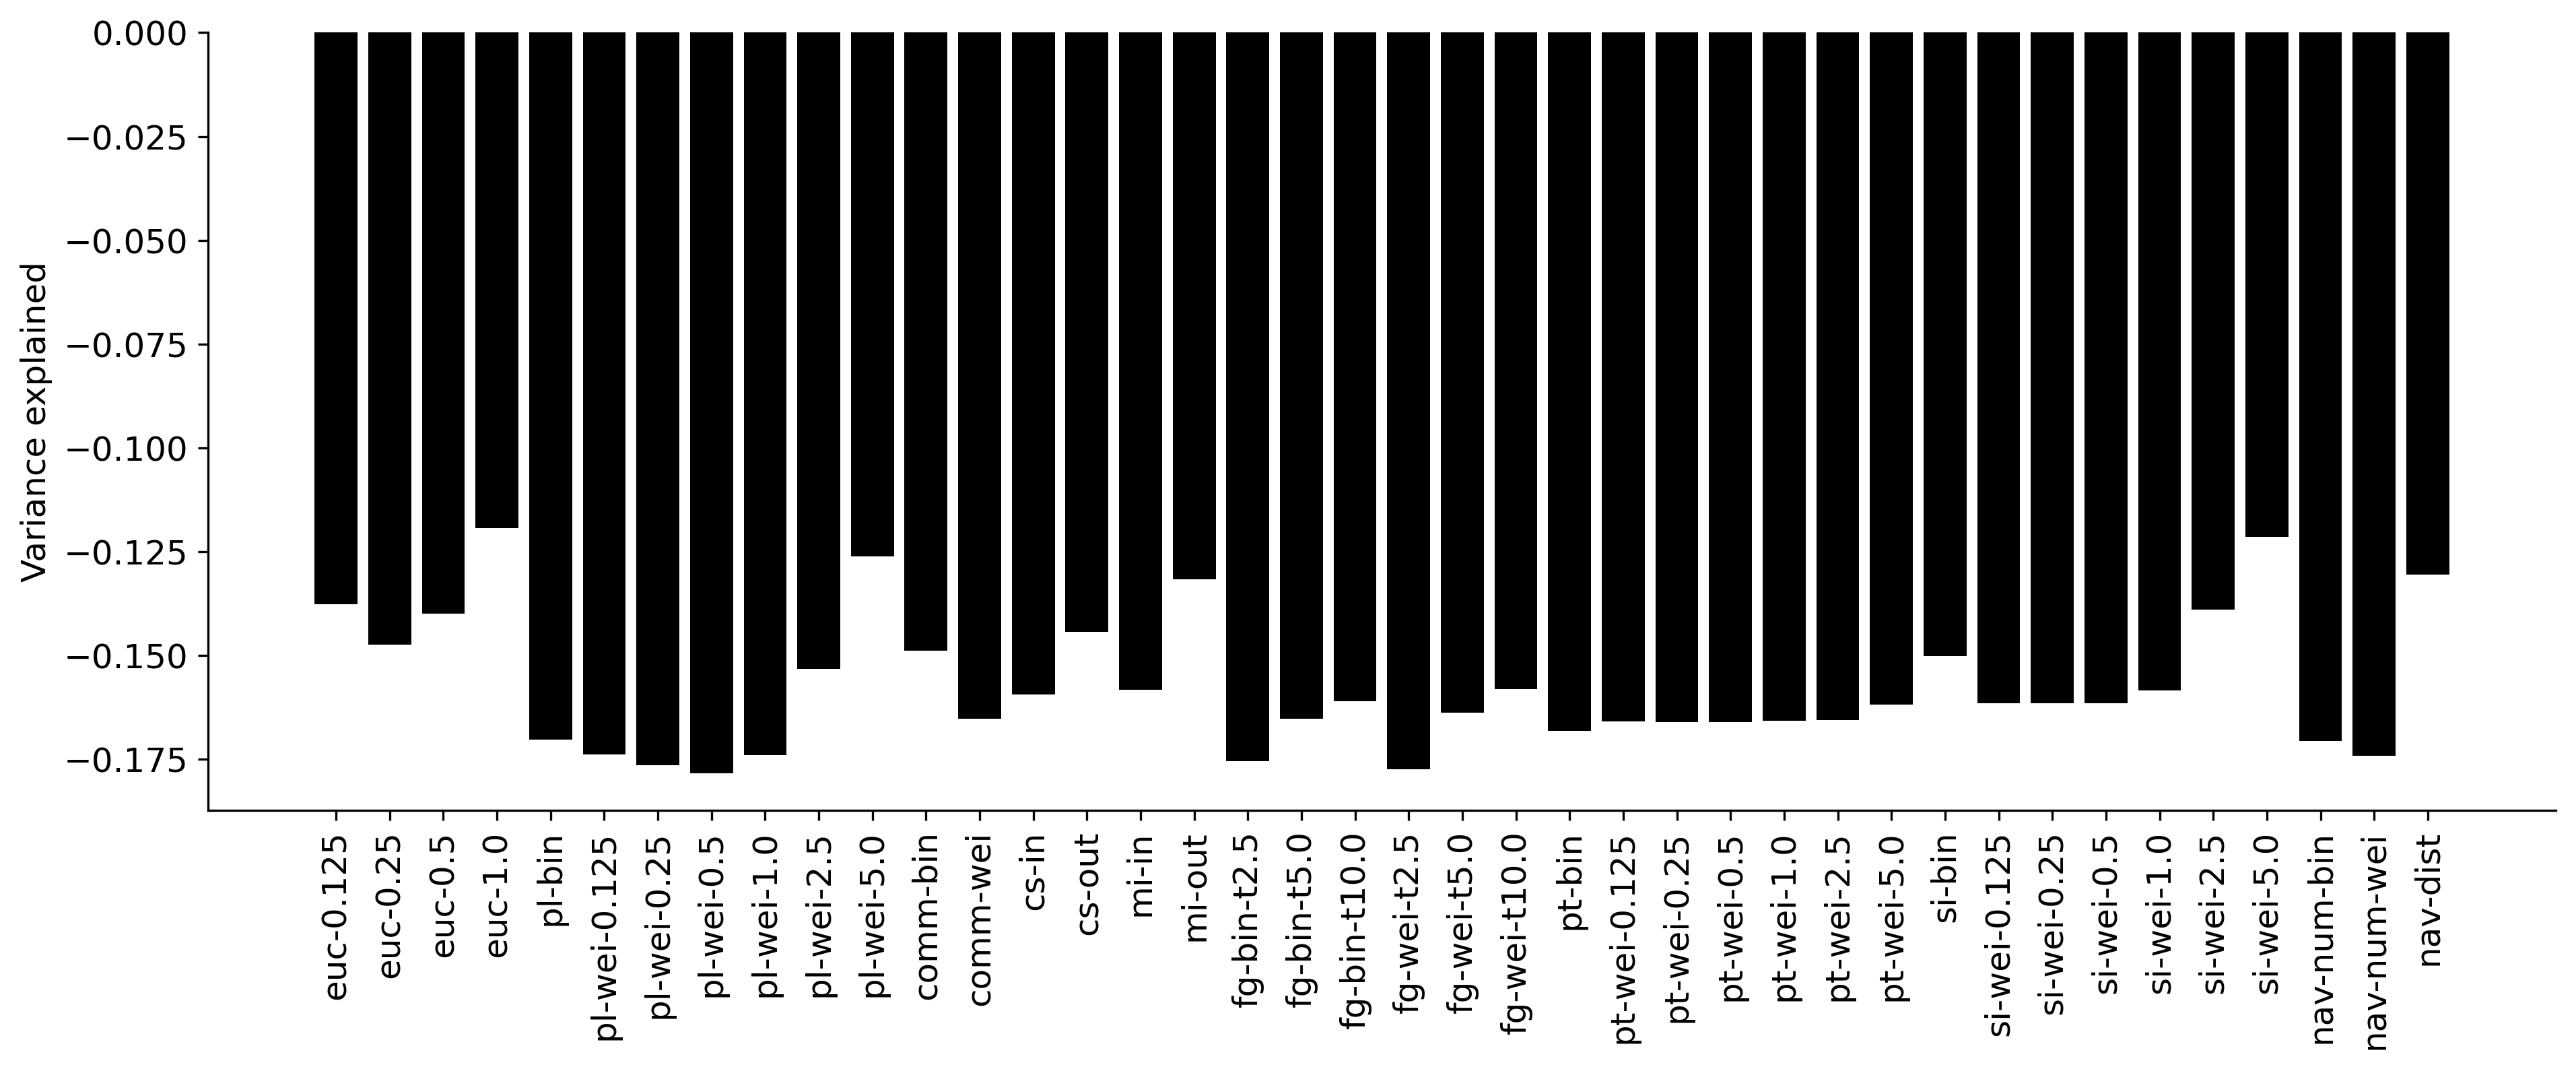

In [37]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
plt.bar(np.arange(model.predictors.shape[1]), loadings[:, 0], color='black', width=0.8)
plt.xticks(np.arange(model.predictors.shape[1]), model.predictors_names, rotation=90)
ax.spines[['top', 'right']].set_visible(False)
plt.ylabel('Variance explained')
plt.show()

In [40]:
triangle = np.triu_indices(PCs[0].shape[0], 1)

In [56]:
avg_predictor = np.mean(np.stack(model.predictors_list, axis=0), axis=0)

In [59]:
pearsonr(PCs[0][triangle], avg_predictor[triangle])

(0.9960960692012744, 0.0)

In [52]:
np.save('Results/figure2_predictor_euc.npy', model.predictors_list[3])
np.save('Results/figure2_predictor_pl.npy', model.predictors_list[8])
np.save('Results/figure2_predictor_comm.npy', model.predictors_list[12])
np.save('Results/figure2_predictor_cs.npy', model.predictors_list[14])

np.save('Results/figure2_sPC1.npy', PCs[0])

In [53]:
def zscore_matrix(matrix):
    normalized = np.copy(matrix)
    normalized -= np.mean(matrix)
    normalized /= np.std(matrix)
    return normalized

def generate_half_matrix(M1, M2):
    triangle = np.triu_indices(M1.shape[0], 1)
    matrix = zscore_matrix(np.copy(M1))
    matrix[triangle] = zscore_matrix(M2)[triangle]
    return matrix

In [54]:
undirected = delete(model.A_und, excluded)

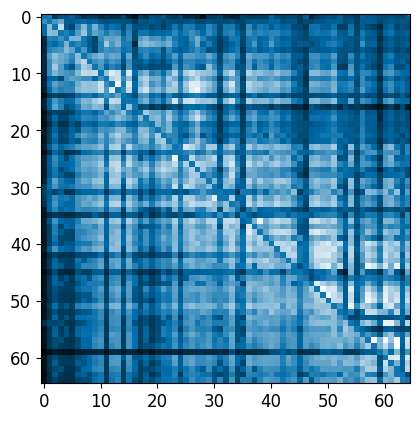

In [55]:
plt.imshow(generate_half_matrix(PCs[0], FC), cmap=cmap)

Text(0, 0.5, 'FC')

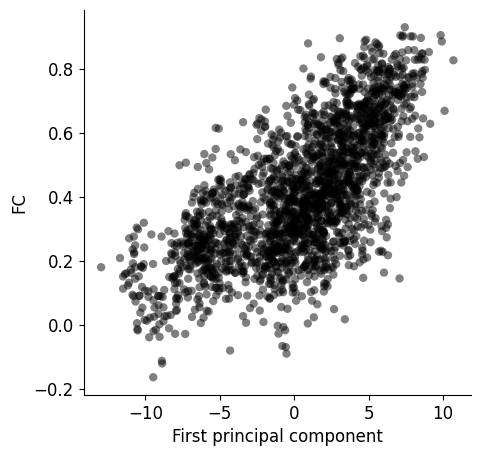

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(PCs[0][triangle], FC[triangle], color='black', alpha=0.5, edgecolor='None')

ax.spines[['top', 'right']].set_visible(False)
plt.xlabel('First principal component')
plt.ylabel('FC')

In [58]:
r_PC1 = pearsonr(PCs[0][triangle], FC[triangle])[0]
print(r_PC1)

0.6843347519756987


# Comparing with structural PC1 from null models

In [60]:
distances = atlas.computeDistanceBetweenRegions()

#### SCCM

In [61]:
null_SC_und, null_SC_dir = np.load('Results/null_SC_und_SCCM.npy'), np.load('Results/null_SC_dir_SCCM.npy')

In [ ]:
null_predictor_correlations_SCCM = []
null_PC1_correlations_SCCM = []

for i in tqdm(range(1000), file=sys.stdout):

    model = Predictors(null_SC_dir[i], null_SC_und[i], distances, excluded=excluded)
    model.compute_predictors(directed=True)

    corrs = model.correlate_single_predictors(FC)
    R = []
    for c in corrs:
        R.append(adjusted_rsquared(c ** 2, N_regions - 1, 1))
    null_predictor_correlations_SCCM.append(R)
    
    predictors = model.predictors
    
    pca = PCA(n_components=1).fit(predictors)
    components = pca.fit_transform(predictors)
    PC1 = components[:, 0].reshape(N_regions, N_regions)
    PC1[np.diag_indices(PC1.shape[0])] = 0

    null_r = pearsonr(PC1[triangle], FC[triangle])[0]
    
    null_PC1_correlations_SCCM.append(null_r)

In [ ]:
np.save('Results/null_predictor_correlations_SCCM.npy', null_predictor_correlations_SCCM)
np.save('Results/null_PC1_correlations_SCCM.npy', null_PC1_correlations_SCCM)

#### CM

In [ ]:
null_SC_und_CM, null_SC_dir_CM = np.load('Results/null_SC_und_CM.npy'), np.load('Results/null_SC_dir_CM.npy')

In [ ]:
null_predictor_correlations_CM = []
null_PC1_correlations_CM = []

for i in tqdm(range(1000), file=sys.stdout):

    model = Predictors(null_SC_dir_CM[i], null_SC_und_CM[i], distances, excluded=excluded)
    model.compute_predictors(directed=True)

    corrs = model.correlate_single_predictors(FC)
    R = []
    for c in corrs:
        R.append(adjusted_rsquared(c ** 2, N_regions - 1, 1))
    null_predictor_correlations_CM.append(R)
    
    predictors = model.predictors
    
    pca = PCA(n_components=1).fit(predictors)
    components = pca.fit_transform(predictors)
    PC1 = components[:, 0].reshape(N_regions, N_regions)
    PC1[np.diag_indices(PC1.shape[0])] = 0

    null_r = pearsonr(PC1[triangle], FC[triangle])[0]
    
    null_PC1_correlations_CM.append(null_r)

In [ ]:
np.save('Results/null_predictor_correlations_CM.npy', null_predictor_correlations_CM)
np.save('Results/null_PC1_correlations_CM.npy', null_PC1_correlations_CM)

#### Loading and inspecting results

In [62]:
null_corrs_SCCM = np.load('Results/null_predictor_correlations_SCCM.npy')
null_PC1_SCCM = np.load('Results/null_PC1_correlations_SCCM.npy')

null_corrs_CM = np.load('Results/null_predictor_correlations_CM.npy')
null_PC1_CM = np.load('Results/null_PC1_correlations_CM.npy')

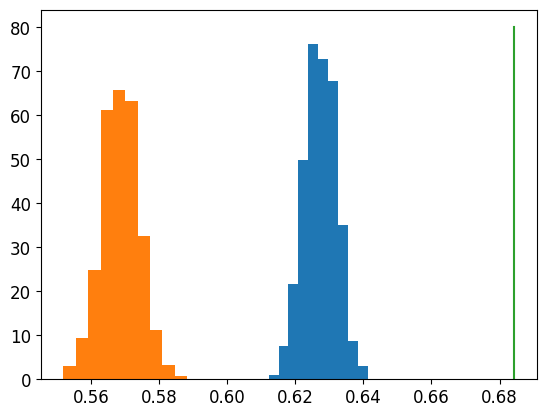

In [63]:
plt.hist(np.abs(null_PC1_SCCM), density=True)
plt.hist(np.abs(null_PC1_CM), density=True)

plt.plot([r_PC1, r_PC1], [0, 80])

In [64]:
percentileofscore(np.abs(null_PC1_SCCM), r_PC1)

100.0

In [65]:
null1 = null_corrs_SCCM[:, 4:]
null2 = null_corrs_CM[:, 4:]
Rsquared = Rsquared_single[4:]
names = model.predictors_names[4:]

np.save('Results/figure2_supp_names.npy', names)
np.save('Results/figure2_supp_rsquared.npy', Rsquared)

In [66]:
p_values = []
for i, R in enumerate(Rsquared):
    perc1 = percentileofscore(null1[:, i], R)
    perc2 = percentileofscore(null2[:, i], R)
    percentile = np.min([perc1, perc2])
    p_values.append((100 - percentile) / 100)

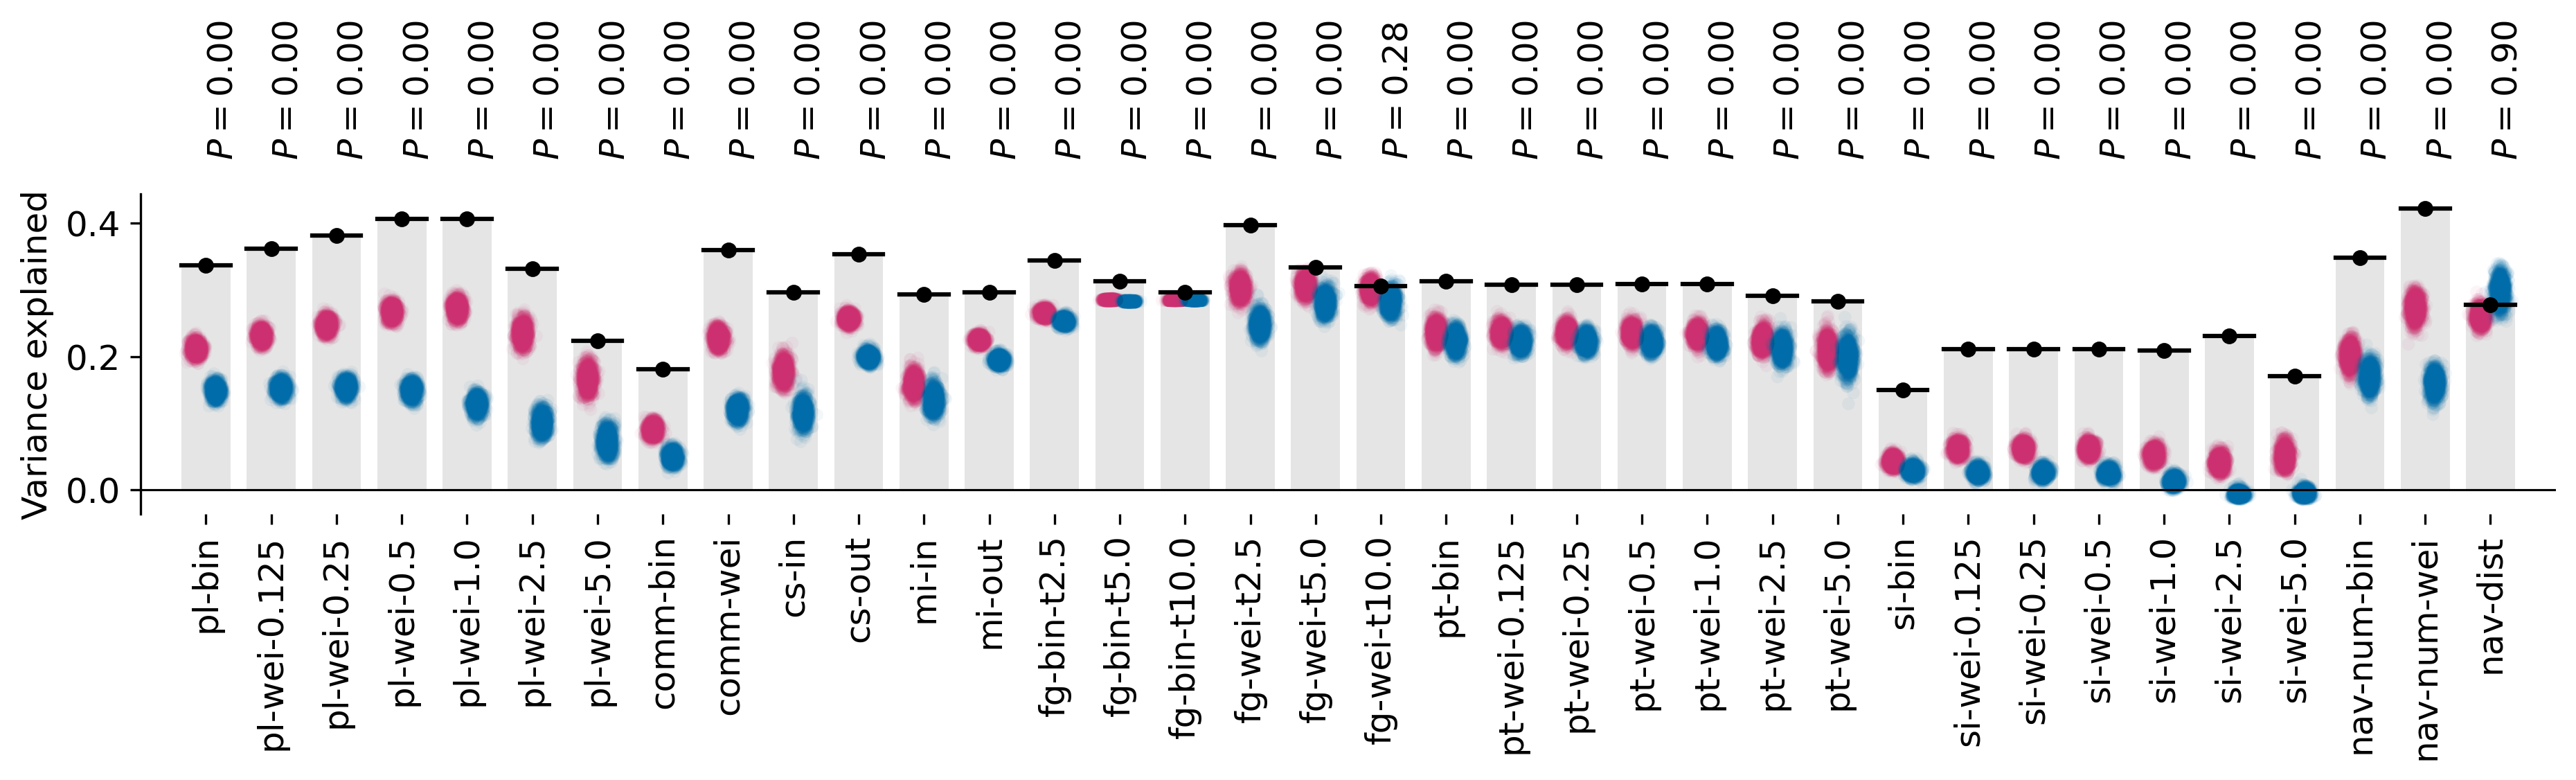

In [68]:
red = np.array([205, 48, 112]) / 255

fig, ax = plt.subplots(figsize=(15, 2), dpi=300)

plt.bar(np.arange(len(Rsquared)), np.abs(Rsquared), color='black', width=0.75, zorder=-10, alpha=0.1)
plt.scatter(np.arange(len(Rsquared)), np.abs(Rsquared), color='black', s=20, zorder=10)

for i in range(len(Rsquared)):
    ax.plot([i - 0.375, i + 0.375], [np.abs(Rsquared)[i], np.abs(Rsquared)[i]], color='black')

for i in range(null1.shape[1]):
    x_values = np.random.normal(i-0.15, 0.05, null1.shape[0])
    plt.scatter(x_values, null1[:, i], color=red, s=20, alpha=0.05, edgecolor='None')

for i in range(null2.shape[1]):
    x_values = np.random.normal(i+0.15, 0.05, null2.shape[0])
    plt.scatter(x_values, null2[:, i], color=blue, s=20, alpha=0.05, edgecolor='None')

for i, p in enumerate(p_values):
    ax.text(i, 0.6, r"$P={:.2f}$".format(p), rotation=90, ha='left', va='center')

ax.plot([0 - 1, null1.shape[1]], [0, 0], color='black', linewidth=0.75)

plt.xticks(np.arange(len(Rsquared)), names, rotation=90)
plt.xlim([-1, len(Rsquared)])
ax.spines[['top', 'right', 'bottom']].set_visible(False)
plt.ylabel('Variance explained')
plt.show()